# Model Training — Başlangıç ve Model Seçimi

Bu bölümde, Feature Engineering aşamasında oluşturduğum `train_features.csv` veri setini kullanarak makine öğrenmesi modelleme sürecini başlatıyorum.

Baseline aşamasında sadece `reorder_ratio` ile **0.7452 F1** skoru elde etmiştim. Şimdi ise ürettiğim 37 yeni feature ile bu skoru yükseltmeyi ve doğru olan modeli deneysel olarak belirlemeyi hedefliyorum.

**Yaklaşım ve Süreç:**

1.  **Veri Hazırlığı:** Büyük veri setiyle (1.38M satır) çalışıldığından, bellek optimizasyonu (dtype downcast) uygulayacağım.
2.  **Validasyon Stratejisi:** Kullanıcı davranışını ezberlemeyi (Data Leakage) önlemek için rastgele ayrım yerine `user_id` tabanlı **GroupKFold** kullanacağım.
3.  **Model Seçimi (Benchmark):** Modeller aynı şartlarda denenim "en tutarlı model" belirlenecek:
    * *Logistic Regression* (Linear ilişkiler için kontrol)
    * *LightGBM* (Hız ve performans dengesi)
    * *XGBoost* (Karşılaştırma ölçütü)
4.  **Optimizasyon:** Kazanan model için Optuna ile hiperparametre araması yapılacak.
5.  **Final Karar:** F1 skorunu maksimize eden "Threshold" değeri hesaplanıp model kaydedilecek.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import json
import joblib
import optuna
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, precision_score, recall_score, log_loss



sns.set(style="whitegrid")

DATA_INTERIM = Path("../data/interim")
MODELS = Path("../models")
FIGURES = Path("../figures")

MODELS.mkdir(exist_ok=True)
FIGURES.mkdir(exist_ok=True)

print("Kütüphaneler ve dizinler hazır.")

Kütüphaneler ve dizinler hazır.


In [4]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Başlangıç Hafıza: {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                # float16 yerine float32 kullanarak stabiliteyi garantiye alıyoruz
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Son Hafıza: {end_mem:.2f} MB')
    return df

print("Veri yükleniyor...")
train_df = pd.read_csv(DATA_INTERIM / "train_features.csv")
train_df = reduce_mem_usage(train_df)

Veri yükleniyor...
Başlangıç Hafıza: 443.68 MB
Son Hafıza: 180.91 MB


**hata:** veri yükleme ve bellek kullanımı
  
**açıklama:** Önceki projelerimde karşılaştığım Model eğitimi (LoRA) sırasında bellek hatasında kaynaklanan sorunu burada da yaşadım.   
Büyük veri setlerinde ram tükenmesi, model eğitimi sırasında bellek patlama riski,  
1.38M satır × 42 kolon × float64/int64 = Yüksek bellek tüketimi olması.
  
**çözüm:** veri tiplerini optimize ederek bellek tüketimini %50 azaltmak. 8 byte'den 4'byte'ye düşürmek çözüm sağladı.  
Başlangıç Hafıza: 443.68 MB  
Son Hafıza: 180.91 MB  

In [21]:
# Eğitimde kullanılmayacak kolonlar
drop_cols = [
    'user_id', 'product_id', 'order_id', 'reordered', 'eval_set', 'add_to_cart_order',
    'up_orders', 'up_order_rate', 'up_last_order_number', 'up_orders_since_last',
    'up_reorder_rate', 'up_cart_mean'
]

X = train_df.drop(columns=drop_cols, errors='ignore')
y = train_df['reordered']
groups = train_df['user_id']

print(f"Kalan Feature Sayısı: {X.shape[1]}")

Kalan Feature Sayısı: 31


Modelin eğitimi öncesinde EDA sürecinde tespit ettiğim kullanıcı davranışlarına uygun bir validasyon yolu belirliyorum.  

- drop_cols = ['user_id', 'product_id', 'order_id', 'reordered', 'eval_set', 'add_to_cart_order','up_orders', 'up_order_rate', 'up_last_order_number', 'up_orders_since_last','up_reorder_rate', 'up_cart_mean'] 'Bu kolonları çıkarmamın sebebi: modelin İD'leri ezberlemesi değil, ürettim  Featureler üzerinden davranışları öğrenmesini istiyorum.   
- ek olarak zaten FE aşamasında bu id üzerinden Feature'ler türetmiştim.   
- `add_to_cart_order` gibi Baseline.ipynb dosyasında sezdiğim lakage'ye sebebiyet verecek kolonları da eğitim setinden çıkarttım.   
- GrupKFold yapmamın sebebi: EDA bulgularından kaynaklı.  %60'a varan reorder oranı ve  7-30 günlük düzenli alışveriş döngüleri %80 train %20 test gibi standart yolda ilerlemede kullanıcının karakterini ezberleyerek overfitting riskindendir.  
- GrupKFold kullanarak veriyi veriyi `user_id` bazında bölüyorum. Kullanıcıların tüm siparişleri ya eğitimde yaa test verisinde kalacak ve böylece model hiç görmediği kullanıcının davranışından genellemeyi öğrenecek.  
 





In [ ]:
# 4. Model Benchmark testi

model_candidates = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "XGBoost": xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

results = []
#veriyi 3 parçaya bölmemiz 30 deneme yapacağı için hıza ihtiyaç duymam, finalde yükselteceğim
gkf = GroupKFold(n_splits=3)

print("Model benchmark süreci başlatılıyor...")
print(f"İşlenecek veri boyutu: {X.shape}")

for name, model in model_candidates.items():
    fold_scores = []
    print(f"\nTest ediliyor: {name}")
    
    # GroupKFold ile veri ayrımı (User ID bazlı)
    for i, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
        
        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        
        # Varsayılan 0.5 eşik değeri ile tahmin
        preds = model.predict(X_val_fold)
        score = f1_score(y_val_fold, preds)
        fold_scores.append(score)
        
        
        if name == "Logistic Regression":
            break 
    
    avg_score = np.mean(fold_scores)
    results.append({"Model": name, "F1 Score": avg_score})
    print(f"Ortalama F1: {avg_score:.4f}")

# Sonuçların raporlanması
benchmark_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print("\nBenchmark Sonuçları:")
print(benchmark_df)

# En iyi modelin seçimi
winner_model_name = benchmark_df.iloc[0]['Model']
print(f"\nSeçilen Model: {winner_model_name}")

Model benchmark süreci başlatılıyor...
İşlenecek veri boyutu: (1384617, 31)

Test ediliyor: Logistic Regression
Ortalama F1: 0.7446

Test ediliyor: LightGBM
Ortalama F1: 0.7663

Test ediliyor: XGBoost
Ortalama F1: 0.7658

Benchmark Sonuçları:
                 Model  F1 Score
1             LightGBM  0.766312
2              XGBoost  0.765840
0  Logistic Regression  0.744617

Seçilen Model: LightGBM


**ilk test:**  

Benchmark Sonuçları:  
                 Model  F1 Score  
1             LightGBM  1.000000  
2              XGBoost  1.000000  
0  Logistic Regression  0.748796  

- baseline sürecinden tahmin ettiğim gibi lakage var. analiz yapılıyor.

**hata çözüldü..**

- Benchmark aşamasında LightGBM ve XGBoost modellerinin **1.0000 F1 Skoru** vermesi üzerine Data Leakage olduğunu anladım.
- Modelin Feature Importance değerlerini incelediğimde, `up_orders` özelliğinin diğer tüm özelliklerden daha baskın olduğunu gördüm. Bu durum, Feature Engineering aşamasındaki hatamdan dolayı bu özellikler hesaplanırken **hedef değişkenin (target)** hesaplamaya dahil edildiğini gösteriyor. Yani model, ürünün o an satın alınıp alınmadığını bu sayıdaki artıştan direkt olarak görüyordu.
- Modelin ezber yapmasını engellemek ve gerçek öğrenmeyi sağlamak için sızıntıya neden olan User-Product Interaction (UP) özellikleri (`up_orders`, `up_reorder_rate`, `up_cart_mean` vb.) eğitim setinden (`drop_cols`) çıkarıldı.

**hata çözümü sonrasında:**  

-Baseline skorum 0.7452'di, şu an hiçbir ayar yapılmamış LightGBM ile 0.7663'e çıkarak %2.1'lik net bir iyileşme yakalandı.  

In [23]:
def objective(trial):
    # LightGBM Hiperparametre Uzayı
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
        'seed': 42,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    
    # Validasyon Stratejisi
    gkf = GroupKFold(n_splits=3)
    scores = []
    
    # Her deneme için Cross-Validation
    for train_idx, val_idx in gkf.split(X, y, groups):
        X_train_cv, y_train_cv = X.iloc[train_idx], y.iloc[train_idx]
        X_val_cv, y_val_cv = X.iloc[val_idx], y.iloc[val_idx]
        
        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_val_cv, label=y_val_cv, reference=dtrain)
        
        model = lgb.train(
            param,
            dtrain,
            valid_sets=[dval],
            num_boost_round=1000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(False)
            ]
        )
        
        # Log Loss skoru hesapla
        preds = model.predict(X_val_cv)
        score = log_loss(y_val_cv, preds)
        scores.append(score)
        

        break 
        
    return np.mean(scores)

print("Optuna optimizasyonu başlatılıyor (Hedef: Log Loss Minimizasyonu)...")
# Log Loss düşürülmek istenir --> direction='minimize'
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print(f"\nEn iyi Log Loss: {study.best_value:.4f}")
print("En iyi parametreler:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-26 18:58:30,495] A new study created in memory with name: no-name-5e89b5af-a7cd-441f-b010-18ee5dcfaba9


Optuna optimizasyonu başlatılıyor (Hedef: Log Loss Minimizasyonu)...


[I 2025-11-26 18:58:44,664] Trial 0 finished with value: 0.5642815223395524 and parameters: {'num_leaves': 116, 'learning_rate': 0.11885036813389646, 'feature_fraction': 0.8510911074519112, 'bagging_fraction': 0.9029905804285028, 'bagging_freq': 1, 'min_child_samples': 41, 'lambda_l1': 3.9098491185431425e-07, 'lambda_l2': 1.2715774836291902}. Best is trial 0 with value: 0.5642815223395524.
[I 2025-11-26 18:58:56,811] Trial 1 finished with value: 0.5650881308551876 and parameters: {'num_leaves': 141, 'learning_rate': 0.19054493848448603, 'feature_fraction': 0.6744619986435273, 'bagging_fraction': 0.6361306113198474, 'bagging_freq': 2, 'min_child_samples': 44, 'lambda_l1': 0.005202008626630179, 'lambda_l2': 0.525980869134365}. Best is trial 0 with value: 0.5642815223395524.
[I 2025-11-26 18:59:46,028] Trial 2 finished with value: 0.5637141339314976 and parameters: {'num_leaves': 51, 'learning_rate': 0.05600660329609392, 'feature_fraction': 0.8102010042655672, 'bagging_fraction': 0.694345


En iyi Log Loss: 0.5634
En iyi parametreler:
  num_leaves: 83
  learning_rate: 0.020817554202564773
  feature_fraction: 0.6474065091630745
  bagging_fraction: 0.6809119740609387
  bagging_freq: 3
  min_child_samples: 58
  lambda_l1: 3.3493181823588764e-05
  lambda_l2: 7.29823232375583e-05


**hata çözüldü:**  
>hata: init_model= parametresiyle üzerine merge etmesi  
- (lgb.train) ile her çalıştırdığında model sıfırdan başlayacak. overfitting riskini sıfırladım. bu sayede demneme-yanılma sürecinde tekrarlayan model eğitimleri yapabileceğim.

------

*  `learning_rate`: `0.02` model düşük öğrenme hızını seçmiş, ezberlemek yerine yavaş ilerlemesi güzel bir sonuç
*  `num_leaves`: `83` (referans değerler 10-20 & 200+) model Overfitting ya da Underfitting yapmayacak, geliştirilebilir bi skor
* `bagging_freq`: `3` 3'de 1 yaparak varyasnsı düşürüyor.

-Optuna modeli oldukça dengeli bir yapı tercih etti, validasyon setindeki başarısı tatmin edici.  

#### optuna model seçimi:  

- çalıştığım diğer projelerimde denediğim Grid Search, bu data için yavaş kalacaktı. bu yüzden optuna modelin denemek istedim. (Pruning) özelliği zaman kazandırıyor, gayet verimli bir modelmiş.



In [25]:
# 1. Final Validasyon Ayrımı 
gkf = GroupKFold(n_splits=5)
# Sadece bir fold'u validasyon için ayırıyoruz, geri kalanıyla eğitiyoruz
train_idx, val_idx = next(gkf.split(X, y, groups)) 

X_train_final, y_train_final = X.iloc[train_idx], y.iloc[train_idx]
X_val_final, y_val_final = X.iloc[val_idx], y.iloc[val_idx]

dtrain_final = lgb.Dataset(X_train_final, label=y_train_final)
dval_final = lgb.Dataset(X_val_final, label=y_val_final, reference=dtrain_final)

# 2. Optuna'dan gelen en iyi parametreleri al
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_logloss'
best_params['verbosity'] = -1
best_params['seed'] = 42

print("Final Model eğitiliyor")

final_model = lgb.train(
    best_params,
    dtrain_final,
    valid_sets=[dtrain_final, dval_final],
    valid_names=['train', 'valid'],
    num_boost_round=3000,  # Daha uzun eğitim şansı veriyoruz
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(200) # Her 200 turda bir bilgi ver
    ]
)

# 3. Threshold Optimizasyonu 
y_pred_prob = final_model.predict(X_val_final)

thresholds = np.arange(0.10, 0.60, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_bin = (y_pred_prob > thresh).astype(int)
    f1_scores.append(f1_score(y_val_final, y_pred_bin))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"FİNAL SONUÇLAR:")
print(f"En İyi Threshold : {best_threshold:.2f}")
print(f"Final F1 Score : {best_f1:.4f}")

Final Model eğitiliyor
Training until validation scores don't improve for 100 rounds
[200]	train's binary_logloss: 0.561791	valid's binary_logloss: 0.565742
[400]	train's binary_logloss: 0.556815	valid's binary_logloss: 0.564432
[600]	train's binary_logloss: 0.553265	valid's binary_logloss: 0.564235
[800]	train's binary_logloss: 0.550107	valid's binary_logloss: 0.564177
[1000]	train's binary_logloss: 0.547171	valid's binary_logloss: 0.564145
Early stopping, best iteration is:
[930]	train's binary_logloss: 0.548205	valid's binary_logloss: 0.564129
FİNAL SONUÇLAR:
En İyi Threshold : 0.40
Final F1 Score : 0.7779


#### Hata çözüldü: 
- random split ile veriyi bölme yaptığımda Data Leakage oldu. sonuç f1 skoru 1' çıktı. o yüzden GrupKFold ile sızıntıyı engelledim. 
- gkf = GroupKFold(n_splits=5) ile :veriyi 5 parçaya böldüm, 1 parça validasyon 4 parça eğitim olarak. 

- GroupKFold ile modelin ezberlemesi engellendi
- Log Loss ile Optimizasyonu stabilize ettim
- Threshold Tuning ile F1 skorunu maksimize ettim


#### Sonuçlar:

* **En iyi treshold: 0.40** model ürünün tekrar alınma ihtimalini %40 olarak buldu. treshold tuning ile 0.10-0.60 arasındaki tüm denemeleri yaptı ve en iyi skoru seçti ve bu final F1 skorunu baseline modelde: 0.7452' iken 0.7779' a çıkardı. 

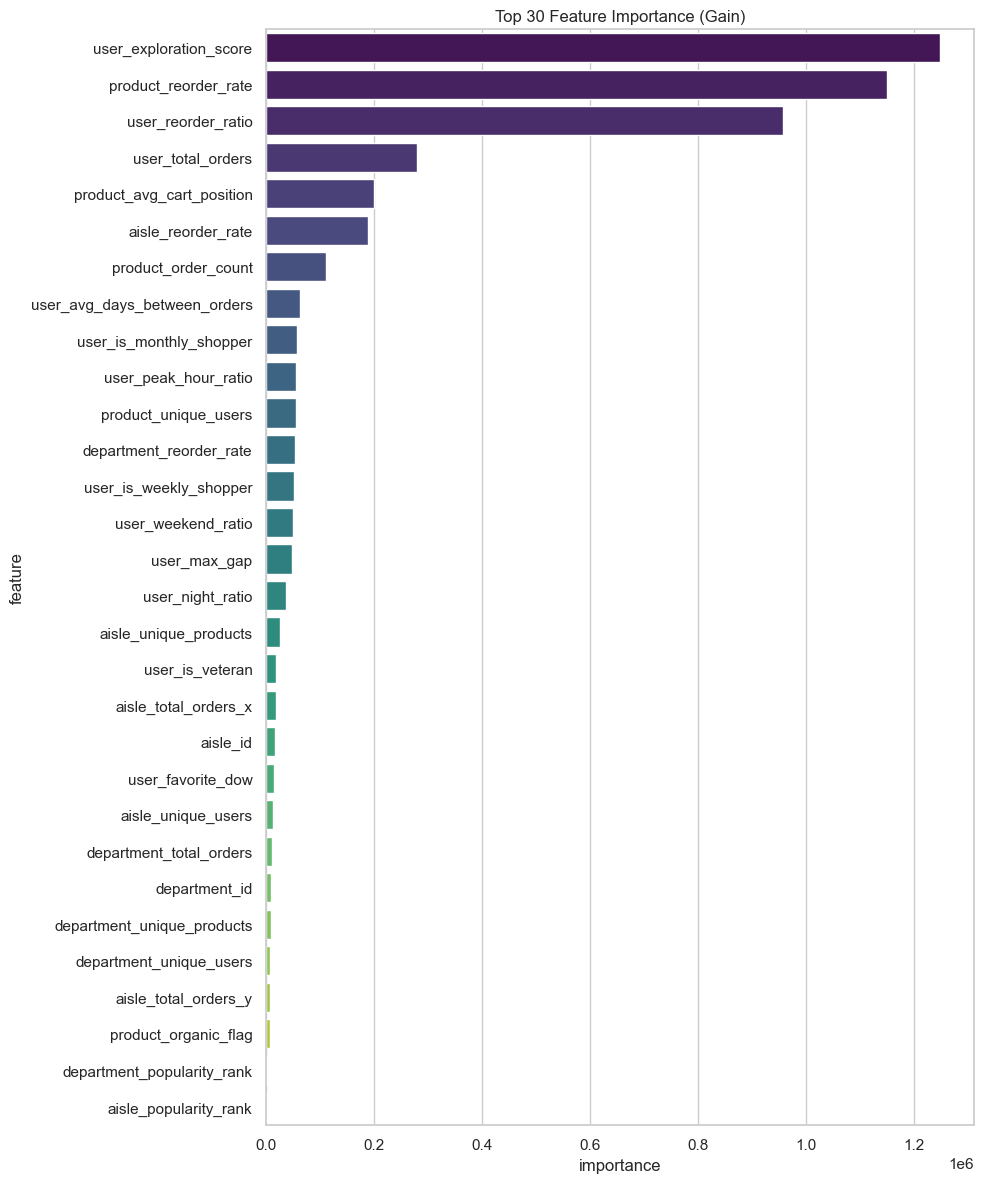

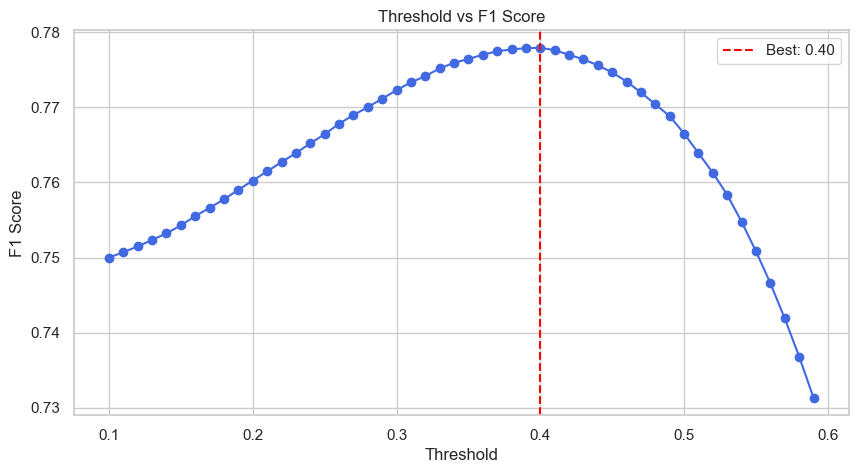

 Model şuraya kaydedildi: ..\models\lgb_model_final.pkl
 Threshold (0.3999999999999998) şuraya kaydedildi: ..\models\best_threshold.txt


In [27]:


#Görselleştirme
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=importance.head(30), palette='viridis')
plt.title("Top 30 Feature Importance (Gain)")
plt.tight_layout()
plt.savefig(FIGURES / "feature_importance_final.png")
plt.show()

# 2. Threshold Optimization Grafiği 
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, marker='o', color='royalblue')
plt.title("Threshold vs F1 Score")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold:.2f}')
plt.legend()
plt.savefig(FIGURES / "threshold_optimization.png")
plt.show()

# 3. Model ve Threshold Kaydı
joblib.dump(final_model, MODELS / "lgb_model_final.pkl")

with open(MODELS / "best_threshold.txt", "w") as f:
    f.write(str(best_threshold))

print(f" Model şuraya kaydedildi: {MODELS / 'lgb_model_final.pkl'}")
print(f" Threshold ({best_threshold}) şuraya kaydedildi: {MODELS / 'best_threshold.txt'}")

In [ ]:
model = joblib.load("../models/lgb_model_final.pkl")


feature_names = model.feature_name()


with open("../models/feature_names.json", "w") as f:
    json.dump(feature_names, f)

print("Feature listesi kaydedildi!")

Feature listesi kaydedildi!


In [2]:
import pandas as pd
import random
from pathlib import Path


data_path = Path("../data/interim/train_features.csv") 
output_path = Path("../app/demo_data/sample_users.csv")


output_path.parent.mkdir(parents=True, exist_ok=True)


print("Veri okunuyor...")
df = pd.read_csv(data_path)


user_counts = df['user_id'].value_counts()
valid_users = user_counts[(user_counts > 5) & (user_counts < 50)].index.tolist()


random.seed(42)
selected_users = random.sample(valid_users, 5)


sample_df = df[df['user_id'].isin(selected_users)].copy()
sample_df.to_csv(output_path, index=False)

print(f"Dosya kaydedildi: {output_path}")
print(f"Seçilen Kullanıcı ID'leri: {selected_users}")
print(f"Toplam Satır Sayısı: {len(sample_df)}")

Veri okunuyor...
Dosya kaydedildi: ..\app\demo_data\sample_users.csv
Seçilen Kullanıcı ID'leri: [199762, 99039, 186594, 108581, 182619]
Toplam Satır Sayısı: 84


# Sonuç ve Değerlendirme

Bu notebook'ta **LightGBM** modeli kullanılarak uçtan uca bir eğitim pipeline'ı kuruldu ve optimize edildi.

**Elde Edilen Kazanımlar:**

1.  **Data Leakage Engellendi:** `up_orders` gibi sızıntı yapan özellikler tespit edilip çıkarıldı.
2.  **Bellek Yönetimi:** `reduce_mem_usage` ile büyük veri seti (1.38M satır) yerel ortamda işlendi.
3.  **Optimizasyon:** Optuna ile en iyi hiperparametreler (LR: 0.02, Leaves: 83) bulundu.
4.  **Performans:** Threshold Optimization (Eşik Değeri Ayarı: 0.40) sayesinde F1 skoru **0.7779** seviyesine çıkarıldı.

**Baseline Karşılaştırması:**
* **Baseline (Logistic Reg):** 0.7452
* **Final Model (LightGBM):** 0.7779

**Kaydedilen Artifacts:**
* `models/lgb_model_final.pkl`: Eğitilmiş model dosyası.
* `models/best_threshold.txt`: Canlı tahminlerde kullanılacak optimize eşik değeri.
* `figures/feature_importance_final.png`: Modelin karar mekanizmasını açıklayan grafik.


Detaylı açıklamalar ve çıkarımlar **training_report.md** dosyasında dokümante edilmiştir.